In [3]:
import gensim
from gensim.models import KeyedVectors
from stellargraph.data import EdgeSplitter
import networkx as nx
from sklearn.linear_model import LogisticRegressionCV
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [16]:
train_df = pd.read_csv('../../../../lm-vol/LANL_train_unique_v2.csv')

In [17]:
train_df

,source user@domain,destination computer,source computer
0,ANONYMOUS LOGON@C1697,C1697,C1697
1,ANONYMOUS LOGON@C586,C586,C1505
2,ANONYMOUS LOGON@C586,C586,C586
3,C10081$@DOM1,C528,C528
4,C101$@DOM1,C988,C988
...,...,...,...
1431275,U8500@DOM1,C529,C1128
1431276,U8500@DOM1,C457,C1128
1431277,U8500@DOM1,C1114,C1115
1431278,U8500@DOM1,C1115,C1115


In [18]:
test_df = pd.read_csv('../../../../lm-vol/LANL_test_unique_v2.csv')

In [19]:
test_df

,source user@domain,destination computer,source computer
0,ANONYMOUS LOGON@C586,C586,C1250
1,ANONYMOUS LOGON@C586,C586,C586
2,C101$@DOM1,C988,C988
3,C1020$@DOM1,C1020,C1020
4,C1021$@DOM1,C625,C1021
...,...,...,...
1062869,U7319@?,C528,C528
1062870,U1345@DOM1,C1640,C23653
1062871,U5462@DOM1,C1065,C17256
1062872,U5462@DOM1,C1065,C1065


In [20]:
model = gensim.models.Word2Vec.load('../../../../lm-vol/2_21_100_epochs_word2vec.model')
wv = KeyedVectors.load('../../../../lm-vol/2_21_100_epochs_word2vec.wordvectors', mmap='r')
G = nx.read_graphml('../../../../lm-vol/LANL_train_unique_v2.graphml')

def operator_hadamard(u, v):
    return u * v

In [15]:
print(wv.key_to_index)

{'C1065': 0, 'C612': 1, 'C457': 2, 'C529': 3, 'C625': 4, 'C528': 5, 'C467': 6, 'C586': 7, 'C2106': 8, 'C1025': 9, 'C1521': 10, 'ANONYMOUS LOGON@C586': 11, 'C706': 12, 'U1653@DOM1': 13, 'C5808': 14, 'C5802': 15, 'C561': 16, 'C5787': 17, 'C231': 18, 'C1798': 19, 'C2109': 20, 'C743': 21, 'C585': 22, 'ANONYMOUS LOGON@C1065': 23, 'ANONYMOUS LOGON@C529': 24, 'ANONYMOUS LOGON@C612': 25, 'ANONYMOUS LOGON@C457': 26, 'ANONYMOUS LOGON@C467': 27, 'U1718@?': 28, 'C395': 29, 'C754': 30, 'ANONYMOUS LOGON@C2106': 31, 'ANONYMOUS LOGON@C528': 32, 'ANONYMOUS LOGON@C754': 33, 'ANONYMOUS LOGON@C625': 34, 'C574': 35, 'C4832': 36, 'C1968': 37, 'C2651': 38, 'C1619': 39, 'C527': 40, 'C1115': 41, 'C1618': 42, 'C105': 43, 'C3758': 44, 'C539': 45, 'C92': 46, 'C423': 47, 'C5453': 48, 'C2039': 49, 'C2521': 50, 'C1567': 51, 'C1611': 52, 'C1382': 53, 'C1089': 54, 'C4159': 55, 'C1503': 56, 'C742': 57, 'C2588': 58, 'C3173': 59, 'C1993': 60, 'C1139': 61, 'C2254': 62, 'C2162': 63, 'C2057': 64, 'C1795': 65, 'C1015': 66, '

In [21]:
with open('../../../../lm-vol/2_21_100_epochs_lr.pkl', 'rb') as file:
    clf = pickle.load(file)

In [22]:
graph_structure = ('source user@domain', 'source computer', 'destination computer')
client_to_ip_pred = []
ip_to_service_pred = []
inconclusive = 0
for index, row in test_df.iterrows():
    try:
        client_embedding = wv[(row[graph_structure[0]])]
        ip_embedding = wv[(row[graph_structure[1]])]
        service_embedding = wv[(row[graph_structure[2]])]
        client_to_ip_embedding = [operator_hadamard(client_embedding, ip_embedding)]
        ip_to_service_embedding = [operator_hadamard(ip_embedding, service_embedding)]
        client_to_ip = clf.predict_proba(client_to_ip_embedding)
        ip_to_service = clf.predict_proba(ip_to_service_embedding)
        client_to_ip_pred.append(client_to_ip[0][1])
        ip_to_service_pred.append(ip_to_service[0][1])
    except: 
        client_to_ip_pred.append(None)
        ip_to_service_pred.append(None)
        inconclusive += 1

In [23]:
len(client_to_ip_pred)

1062874

In [24]:
test_df['client_to_ip'] = client_to_ip_pred
test_df['ip_to_service'] = ip_to_service_pred

In [25]:
anomalous_edges = len(test_df[(test_df["ip_to_service"].astype(float) <= 0.1) | (test_df["client_to_ip"].astype(float) <= 0.1)])
normal_edges = len(test_df[(test_df["ip_to_service"].astype(float) > 0.1) & (test_df["client_to_ip"].astype(float) > 0.1)])
print(anomalous_edges/(normal_edges+anomalous_edges))
print(anomalous_edges)
print(normal_edges)

0.38087860631114634
350574
569861


In [26]:
anomaly_df = test_df[(test_df['ip_to_service'].astype(float) <= 0.1) | (test_df["client_to_ip"].astype(float) <= 0.1)]
anomaly_df

,source user@domain,destination computer,source computer,client_to_ip,ip_to_service
0,ANONYMOUS LOGON@C586,C586,C1250,8.953679e-01,0.000255
1,ANONYMOUS LOGON@C586,C586,C586,2.577477e-21,1.000000
4,C1021$@DOM1,C625,C1021,9.342245e-01,0.002538
5,C1035$@DOM1,C586,C1035,9.528795e-01,0.000012
13,C119$@DOM1,C528,C119,2.880482e-01,0.002926
...,...,...,...,...,...
1062860,U1345@DOM1,C2106,C23653,9.829671e-01,0.000006
1062861,C21535$@DOM1,C625,C21535,2.580437e-01,0.000005
1062865,U9695@DOM1,C625,C11120,9.940113e-01,0.003599
1062866,C8842$@DOM1,C612,C18234,6.173649e-01,0.000002


In [27]:
for index, row in anomaly_df.iterrows():
    involved = (row['source user@domain'], row['source computer'], row['destination computer'])
    # get 10 most similiar sources
    similar_sources, similar_source_score = zip(*wv.most_similar(positive=[row['source user@domain']]))
    # get 10 most similar ips
    similar_ips, similar_ip_score = zip(*wv.most_similar(positive=[row['source computer']]))
    # get 10 most similar services
    similar_service, similar_service_score = zip(*wv.most_similar(positive=[row['destination computer']]))
    nodes = list(set(involved + similar_sources + similar_ips + similar_service))
    break

In [28]:
anomalies = []
for index, row in anomaly_df.iterrows():
    anomaly = [row['source user@domain'], row['source computer'], row['destination computer']]
    anomalies.append(anomaly)

In [29]:
def explain_graph(anomaly, train_graph):
    
    def filter_node(node):
        return node in filtered_nodes
    
    client_node, ip_node, service_node = anomaly
    involved = (client_node, ip_node, service_node)
    # get 10 most similiar sources
    similar_sources, similar_source_score = zip(*wv.most_similar(positive=[client_node])[:3])
    # get 10 most similar ips
    similar_ips, similar_ip_score = zip(*wv.most_similar(positive=[ip_node])[:3])
    # get 10 most similar services
    similar_service, similar_service_score = zip(*wv.most_similar(positive=[service_node])[:3])
    filtered_nodes = list(set(involved + similar_sources + similar_ips + similar_service))
    view = nx.subgraph_view(train_graph, filter_node = filter_node)
    ColorScale = plt.get_cmap('RdYlGn')
    subgraph = nx.Graph(view)
    subgraph.add_edge(client_node, ip_node)
    subgraph.add_edge(ip_node, service_node)
    for edge in subgraph.edges:
        src, dest = edge
        edge_embedding = [operator_hadamard(model.wv[src],model.wv[dest])]
        edge_prob = clf.predict_proba(edge_embedding)
        subgraph[src][dest]['prob'] = ColorScale(edge_prob[0][1])
    node_colors = []
    for node in subgraph.nodes:
        if node == client_node:
            node_colors.append('yellow')
        elif node == ip_node:
            node_colors.append('orange')
        elif node == service_node:
            node_colors.append('red')
        else:
            node_colors.append('#1f77b4')
    edge_colors = [x[2] for x in subgraph.edges.data('prob')]
    nx.draw(subgraph, edge_color=edge_colors, node_color=node_colors, with_labels=True)

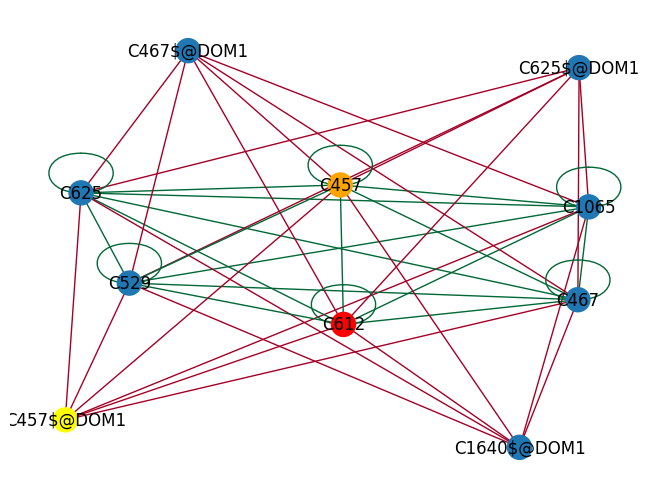

In [30]:
explain_graph(anomalies[75], G)